# KinD Implementation

**Description:** Kindling the Darkness: a Practical Low-light Image Enhancer.

In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats as st
import tensorflow as tf
import tensorflow.contrib.slim as slim
import os, time, random
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tensorflow.contrib.layers.python.layers import initializers
from skimage import io,data,color,filters
from functools import reduce

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# 1- Data Augmentation + Load & Save Images

In [2]:
def gauss_kernel(kernlen=21, nsig=3, channels=1):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    out_filter = np.array(kernel, dtype = np.float32)
    out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
    out_filter = np.repeat(out_filter, channels, axis = 2)
    return out_filter

def tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()[1:]), 1)

def blur(x):
    kernel_var = gauss_kernel(21, 3, 3)
    return tf.nn.depthwise_conv2d(x, kernel_var, [1, 1, 1, 1], padding='SAME')

def tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()[1:]), 1)

def data_augmentation(image, mode):
    if mode == 0:
        # original
        return image
    elif mode == 1:
        # flip up and down
        return np.flipud(image)
    elif mode == 2:
        # rotate counterwise 90 degree
        return np.rot90(image)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        image = np.rot90(image)
        return np.flipud(image)
    elif mode == 4:
        # rotate 180 degree
        return np.rot90(image, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        image = np.rot90(image, k=2)
        return np.flipud(image)
    elif mode == 6:
        # rotate 270 degree
        return np.rot90(image, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        image = np.rot90(image, k=3)
        return np.flipud(image)

def load_images(file):
    im = Image.open(file)
    img = np.array(im, dtype="float32") / 255.0
    img_max = np.max(img)
    img_min = np.min(img)
    img_norm = np.float32((img - img_min) / np.maximum((img_max - img_min), 0.001))
    return img_norm

def gradient(input_tensor, direction):
    smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
    smooth_kernel_y = tf.transpose(smooth_kernel_x, [1, 0, 2, 3])
    if direction == "x":
        kernel = smooth_kernel_x
    elif direction == "y":
        kernel = smooth_kernel_y
    gradient_orig = tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))
    grad_min = tf.reduce_min(gradient_orig)
    grad_max = tf.reduce_max(gradient_orig)
    grad_norm = tf.div((gradient_orig - grad_min), (grad_max - grad_min + 0.0001))
    return grad_norm

def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)),
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def save_images(filepath, result_1, result_2 = None, result_3 = None):
    result_1 = np.squeeze(result_1)
    result_2 = np.squeeze(result_2)
    result_3 = np.squeeze(result_3)

    if not result_2.any():
        cat_image = result_1
    else:
        cat_image = np.concatenate([result_1, result_2], axis = 1)
    if not result_3.any():
        cat_image = cat_image
    else:
        cat_image = np.concatenate([cat_image, result_3], axis = 1)

    im = Image.fromarray(np.clip(cat_image * 255.0, 0, 255.0).astype('uint8'))
    im.save(filepath, 'png')


# 2 - Model Architecture
**KinD Model is the combination of three Models working in the sequence**
1. DecomNet_simple
2. Restoration_net
3. Illumination_adjust_net

In [3]:
def lrelu(x, trainbable=None):
    return tf.maximum(x*0.2,x)

def upsample_and_concat(x1, x2, output_channels, in_channels, scope_name, trainable=True):
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        pool_size = 2
        deconv_filter = tf.get_variable('weights', [pool_size, pool_size, output_channels, in_channels], trainable= True)
        deconv = tf.nn.conv2d_transpose(x1, deconv_filter, tf.shape(x2) , strides=[1, pool_size, pool_size, 1], name=scope_name)

        deconv_output =  tf.concat([deconv, x2],3)
        deconv_output.set_shape([None, None, None, output_channels*2])

        return deconv_output

def DecomNet_simple(input):
    with tf.variable_scope('DecomNet', reuse=tf.AUTO_REUSE):
        conv1=slim.conv2d(input,32,[3,3], rate=1, activation_fn=lrelu,scope='g_conv1_1')
        pool1=slim.max_pool2d(conv1, [2, 2], stride = 2, padding='SAME' )
        conv2=slim.conv2d(pool1,64,[3,3], rate=1, activation_fn=lrelu,scope='g_conv2_1')
        pool2=slim.max_pool2d(conv2, [2, 2], stride = 2, padding='SAME' )
        conv3=slim.conv2d(pool2,128,[3,3], rate=1, activation_fn=lrelu,scope='g_conv3_1')
        up8 =  upsample_and_concat( conv3, conv2, 64, 128 , 'g_up_1')
        conv8=slim.conv2d(up8,  64,[3,3], rate=1, activation_fn=lrelu,scope='g_conv8_1')
        up9 =  upsample_and_concat( conv8, conv1, 32, 64 , 'g_up_2')
        conv9=slim.conv2d(up9,  32,[3,3], rate=1, activation_fn=lrelu,scope='g_conv9_1')
        # Here, we use 1*1 kernel to replace the 3*3 ones in the paper to get better results.
        conv10=slim.conv2d(conv9,3,[1,1], rate=1, activation_fn=None, scope='g_conv10')
        R_out = tf.sigmoid(conv10)

        l_conv2=slim.conv2d(conv1,32,[3,3], rate=1, activation_fn=lrelu,scope='l_conv1_2')
        l_conv3=tf.concat([l_conv2, conv9],3)
        # Here, we use 1*1 kernel to replace the 3*3 ones in the paper to get better results.
        l_conv4=slim.conv2d(l_conv3,1,[1,1], rate=1, activation_fn=None,scope='l_conv1_4')
        L_out = tf.sigmoid(l_conv4)

    return R_out, L_out

def Restoration_net(input_r, input_i):
    with tf.variable_scope('Restoration_net', reuse=tf.AUTO_REUSE):
        input_all = tf.concat([input_r,input_i], 3)
        
        conv1=slim.conv2d(input_all,32,[3,3], rate=1, activation_fn=lrelu,scope='de_conv1_1')
        conv1=slim.conv2d(conv1,32,[3,3], rate=1, activation_fn=lrelu,scope='de_conv1_2')
        pool1=slim.max_pool2d(conv1, [2, 2], padding='SAME' )

        conv2=slim.conv2d(pool1,64,[3,3], rate=1, activation_fn=lrelu,scope='de_conv2_1')
        conv2=slim.conv2d(conv2,64,[3,3], rate=1, activation_fn=lrelu,scope='de_conv2_2')
        pool2=slim.max_pool2d(conv2, [2, 2], padding='SAME' )

        conv3=slim.conv2d(pool2,128,[3,3], rate=1, activation_fn=lrelu,scope='de_conv3_1')
        conv3=slim.conv2d(conv3,128,[3,3], rate=1, activation_fn=lrelu,scope='de_conv3_2')
        pool3=slim.max_pool2d(conv3, [2, 2], padding='SAME' )

        conv4=slim.conv2d(pool3,256,[3,3], rate=1, activation_fn=lrelu,scope='de_conv4_1')
        conv4=slim.conv2d(conv4,256,[3,3], rate=1, activation_fn=lrelu,scope='de_conv4_2')
        pool4=slim.max_pool2d(conv4, [2, 2], padding='SAME' )

        conv5=slim.conv2d(pool4,512,[3,3], rate=1, activation_fn=lrelu,scope='de_conv5_1')
        conv5=slim.conv2d(conv5,512,[3,3], rate=1, activation_fn=lrelu,scope='de_conv5_2')

        up6 =  upsample_and_concat( conv5, conv4, 256, 512, 'up_6')

        conv6=slim.conv2d(up6,  256,[3,3], rate=1, activation_fn=lrelu,scope='de_conv6_1')
        conv6=slim.conv2d(conv6,256,[3,3], rate=1, activation_fn=lrelu,scope='de_conv6_2')

        up7 =  upsample_and_concat( conv6, conv3, 128, 256, 'up_7'  )
        conv7=slim.conv2d(up7,  128,[3,3], rate=1, activation_fn=lrelu,scope='de_conv7_1')
        conv7=slim.conv2d(conv7,128,[3,3], rate=1, activation_fn=lrelu,scope='de_conv7_2')

        up8 =  upsample_and_concat( conv7, conv2, 64, 128, 'up_8' )
        conv8=slim.conv2d(up8,  64,[3,3], rate=1, activation_fn=lrelu,scope='de_conv8_1')
        conv8=slim.conv2d(conv8,64,[3,3], rate=1, activation_fn=lrelu,scope='de_conv8_2')

        up9 =  upsample_and_concat( conv8, conv1, 32, 64, 'up_9' )
        conv9=slim.conv2d(up9,  32,[3,3], rate=1, activation_fn=lrelu,scope='de_conv9_1')
        conv9=slim.conv2d(conv9,32,[3,3], rate=1, activation_fn=lrelu,scope='de_conv9_2')

        conv10=slim.conv2d(conv9,3,[3,3], rate=1, activation_fn=None, scope='de_conv10')
    
        out = tf.sigmoid(conv10)
        return out

def Illumination_adjust_net(input_i, input_ratio):
    with tf.variable_scope('Illumination_adjust_net', reuse=tf.AUTO_REUSE):
        input_all = tf.concat([input_i, input_ratio], 3)
        
        conv1=slim.conv2d(input_all,32,[3,3], rate=1, activation_fn=lrelu,scope='en_conv_1')
        conv2=slim.conv2d(conv1,32,[3,3], rate=1, activation_fn=lrelu,scope='en_conv_2')
        conv3=slim.conv2d(conv2,32,[3,3], rate=1, activation_fn=lrelu,scope='en_conv_3')
        conv4=slim.conv2d(conv3,1,[3,3], rate=1, activation_fn=lrelu,scope='en_conv_4')

        L_enhance = tf.sigmoid(conv4)
    return L_enhance

# 3 - Decomposition-Net Train

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[*] Initialize model successfully...
[*] Number of training data: 494
loaded ./checkpoint/decom_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/decom_net_train/model.ckpt
[*] Start training for phase decomposition, with start epoch 0 start iter 0 : 
decomposition Epoch: [ 1] [  49/  49] time: 6.6652, loss: 0.058577, accuracy: 0.9217
decomposition Epoch: [ 2] [  49/  49] time: 13.2751, loss: 0.094361, accuracy: 0.9277
decomposition Epoch: [ 3] [  49/  49] time: 19.7928, loss: 0.061497, accuracy: 0.9163
decomposition Epoch: [ 4] [  49/  49] time: 26.3284, loss: 0.092642, accuracy: 0.9273
decomposition Epoch: [ 5] [  49/  49] time: 32.8876, loss: 0.063126, accuracy: 0.9245
decomposition Epoch: [ 6] [  49/  49] time: 39.476

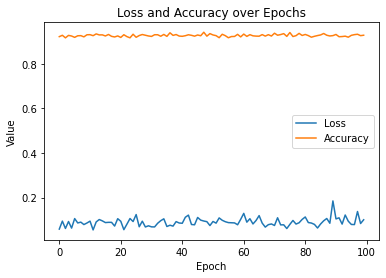

[*] Finish training for phase decomposition.


In [4]:
batch_size = 10
patch_size = 48

sess = tf.Session()

input_low = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low')
input_high = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high')

[R_low, I_low] = DecomNet_simple(input_low)
[R_high, I_high] = DecomNet_simple(input_high)

I_low_3 = tf.concat([I_low, I_low, I_low], axis=3)
I_high_3 = tf.concat([I_high, I_high, I_high], axis=3)

#network output
output_R_low = R_low
output_R_high = R_high
output_I_low = I_low_3
output_I_high = I_high_3

# define loss

def mutual_i_loss(input_I_low, input_I_high):
    low_gradient_x = gradient(input_I_low, "x")
    high_gradient_x = gradient(input_I_high, "x")
    x_loss = (low_gradient_x + high_gradient_x)* tf.exp(-10*(low_gradient_x+high_gradient_x))
    low_gradient_y = gradient(input_I_low, "y")
    high_gradient_y = gradient(input_I_high, "y")
    y_loss = (low_gradient_y + high_gradient_y) * tf.exp(-10*(low_gradient_y+high_gradient_y))
    mutual_loss = tf.reduce_mean( x_loss + y_loss) 
    return mutual_loss

def mutual_i_input_loss(input_I_low, input_im):
    input_gray = tf.image.rgb_to_grayscale(input_im)
    low_gradient_x = gradient(input_I_low, "x")
    input_gradient_x = gradient(input_gray, "x")
    x_loss = tf.abs(tf.div(low_gradient_x, tf.maximum(input_gradient_x, 0.01)))
    low_gradient_y = gradient(input_I_low, "y")
    input_gradient_y = gradient(input_gray, "y")
    y_loss = tf.abs(tf.div(low_gradient_y, tf.maximum(input_gradient_y, 0.01)))
    mut_loss = tf.reduce_mean(x_loss + y_loss) 
    return mut_loss

recon_loss_low = tf.reduce_mean(tf.abs(R_low * I_low_3 -  input_low))
recon_loss_high = tf.reduce_mean(tf.abs(R_high * I_high_3 - input_high))

equal_R_loss = tf.reduce_mean(tf.abs(R_low - R_high))

i_mutual_loss = mutual_i_loss(I_low, I_high)

i_input_mutual_loss_high = mutual_i_input_loss(I_high, input_high)
i_input_mutual_loss_low = mutual_i_input_loss(I_low, input_low)

#######################################################################################
# Accuracy calculation
def calculate_accuracy(prediction, target):
    # Assuming prediction and target are of shape [batch_size, height, width, channels]
    # Convert them to grayscale
    prediction_gray = tf.image.rgb_to_grayscale(prediction)
    target_gray = tf.image.rgb_to_grayscale(target)
    
    # Calculate absolute difference
    diff = tf.abs(prediction_gray - target_gray)
    
    # Threshold the difference to obtain binary mask
    threshold = tf.constant(0.2)  # Adjust the threshold as needed
    mask = tf.cast(tf.less(diff, threshold), tf.float32)
    
    # Calculate accuracy as the percentage of pixels within the threshold
    accuracy = tf.reduce_mean(mask)
    return accuracy
#######################################################################################

loss_Decom = 1*recon_loss_high + 1*recon_loss_low \
               + 0.01 * equal_R_loss + 0.2*i_mutual_loss \
             + 0.15* i_input_mutual_loss_high + 0.15* i_input_mutual_loss_low

#######################################################################################
accuracy_low = calculate_accuracy(output_I_low, input_low)
accuracy_high = calculate_accuracy(output_I_high, input_high)
accuracy = (accuracy_low + accuracy_high) / 2.0  # Average accuracy
#######################################################################################

###
lr = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='AdamOptimizer')
var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]

train_op_Decom = optimizer.minimize(loss_Decom, var_list = var_Decom)
sess.run(tf.global_variables_initializer())

saver_Decom = tf.train.Saver(var_list = var_Decom)
print("[*] Initialize model successfully...")

#load data
###train_data
train_low_data = []
train_high_data = []
train_low_data_names = glob('./LOLdataset/our485/low/*.png') 
train_low_data_names.sort()
train_high_data_names = glob('./LOLdataset/our485/high/*.png') 
train_high_data_names.sort()
assert len(train_low_data_names) == len(train_high_data_names)
print('[*] Number of training data: %d' % len(train_low_data_names))
for idx in range(len(train_low_data_names)):
    low_im = load_images(train_low_data_names[idx])
    train_low_data.append(low_im)
    high_im = load_images(train_high_data_names[idx])
    train_high_data.append(high_im)
###eval_data
eval_low_data = []
eval_high_data = []
eval_low_data_name = glob('./LOLdataset/eval15/low/*.png')
eval_low_data_name.sort()
eval_high_data_name = glob('./LOLdataset/eval15/high/*.png*')
eval_high_data_name.sort()
for idx in range(len(eval_low_data_name)):
    eval_low_im = load_images(eval_low_data_name[idx])
    eval_low_data.append(eval_low_im)
    eval_high_im = load_images(eval_high_data_name[idx])
    eval_high_data.append(eval_high_im)

# epoch = 2000
epoch = 100
learning_rate = 0.0001

sample_dir = './Decom_net_train/'
if not os.path.isdir(sample_dir):
    os.makedirs(sample_dir)

eval_every_epoch = 200
train_phase = 'decomposition'
numBatch = len(train_low_data) // int(batch_size)
train_op = train_op_Decom
train_loss = loss_Decom
saver = saver_Decom

checkpoint_dir = './checkpoint/decom_net_train/'
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
ckpt=tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded '+ckpt.model_checkpoint_path)
    saver.restore(sess,ckpt.model_checkpoint_path)

start_step = 0
start_epoch = 0
iter_num = 0
print("[*] Start training for phase %s, with start epoch %d start iter %d : " % (train_phase, start_epoch, iter_num))

start_time = time.time()
image_id = 0

######################################
# Lists to store epoch and loss values
epoch_list = []
loss_list = []
accuracy_list = []  # Initialize accuracy list
######################################

for epoch in range(start_epoch, epoch):
    
    ##################
    accuracy_sum = 0.0
    ##################
    
    for batch_id in range(start_step, numBatch):
        batch_input_low = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
        batch_input_high = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
        for patch_id in range(batch_size):
            h, w, _ = train_low_data[image_id].shape
            x = random.randint(0, h - patch_size)
            y = random.randint(0, w - patch_size)
            rand_mode = random.randint(0, 7)
            batch_input_low[patch_id, :, :, :] = data_augmentation(train_low_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)
            batch_input_high[patch_id, :, :, :] = data_augmentation(train_high_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)
            image_id = (image_id + 1) % len(train_low_data)
            if image_id == 0:
                tmp = list(zip(train_low_data, train_high_data))
                random.shuffle(tmp)
                train_low_data, train_high_data  = zip(*tmp)
        
        ################################################################################################################
        _, loss, batch_accuracy = sess.run([train_op, train_loss, accuracy], feed_dict={input_low: batch_input_low, \
                                                                                         input_high: batch_input_high, \
                                                                                         lr: learning_rate})
        accuracy_sum += batch_accuracy
        ################################################################################################################
        
        #_, loss = sess.run([train_op, train_loss], feed_dict={input_low: batch_input_low, \
        #                                                      input_high: batch_input_high, \
        #                                                      lr: learning_rate})
        
        average_accuracy = accuracy_sum / numBatch
        # print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f, accuracy: %.4f" \
        #     % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss, average_accuracy))

        #print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
        #    % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
        iter_num += 1

    print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f, accuracy: %.4f" \
        % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss, average_accuracy))

    
    ###########################################    
    # Append epoch and loss values to the lists
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(average_accuracy)  # Append average accuracy for the epoch
    ###########################################
    
    if (epoch + 1) % eval_every_epoch == 0:
        print("[*] Evaluating for phase %s / epoch %d..." % (train_phase, epoch + 1))
        for idx in range(len(eval_low_data)):
            input_low_eval = np.expand_dims(eval_low_data[idx], axis=0)
            result_1, result_2 = sess.run([output_R_low, output_I_low], feed_dict={input_low: input_low_eval})
            save_images(os.path.join(sample_dir, 'low_%d_%d.png' % ( idx + 1, epoch + 1)), result_1, result_2)
        for idx in range(len(eval_high_data)):
            input_high_eval = np.expand_dims(eval_high_data[idx], axis=0)
            result_11, result_22 = sess.run([output_R_high, output_I_high], feed_dict={input_high: input_high_eval})
            save_images(os.path.join(sample_dir, 'high_%d_%d.png' % ( idx + 1, epoch + 1)), result_11, result_22)
         
    saver.save(sess, checkpoint_dir + 'model.ckpt')
    
# Plot the loss and accuracy on the same graph
plt.plot(epoch_list, loss_list, label='Loss')
plt.plot(epoch_list, accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy over Epochs')
plt.legend()

# Save the combined graph
plt.savefig(os.path.join(sample_dir, 'combined_graph.png'))

# Show the combined graph
plt.show()

print("[*] Finish training for phase %s." % train_phase)

# 4 - Adjustment-Net Train

In [4]:
batch_size = 10
patch_size = 48

sess = tf.Session()
#the input of decomposition net
input_decom = tf.placeholder(tf.float32, [None, None, None, 3], name='input_decom')
#the input of illumination adjustment net
input_low_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i')
input_low_i_ratio = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i_ratio')
input_high_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_high_i')

[R_decom, I_decom] = DecomNet_simple(input_decom)
#the output of decomposition network
decom_output_R = R_decom
decom_output_I = I_decom
#the output of illumination adjustment net
output_i = Illumination_adjust_net(input_low_i, input_low_i_ratio)

#define loss

def grad_loss(input_i_low, input_i_high):
    x_loss = tf.square(gradient(input_i_low, 'x') - gradient(input_i_high, 'x'))
    y_loss = tf.square(gradient(input_i_low, 'y') - gradient(input_i_high, 'y'))
    grad_loss_all = tf.reduce_mean(x_loss + y_loss)
    return grad_loss_all

loss_grad = grad_loss(output_i, input_high_i)
loss_square = tf.reduce_mean(tf.square(output_i  - input_high_i))# * ( 1 - input_low_r ))#* (1- input_low_i)))

loss_adjust =  loss_square + loss_grad 

lr = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='AdamOptimizer')

var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
var_adjust = [var for var in tf.trainable_variables() if 'Illumination_adjust_net' in var.name]

saver_adjust = tf.train.Saver(var_list=var_adjust)
saver_Decom = tf.train.Saver(var_list = var_Decom)
train_op_adjust = optimizer.minimize(loss_adjust, var_list = var_adjust)
sess.run(tf.global_variables_initializer())
print("[*] Initialize model successfully...")

### load data
### Based on the decomposition net, we first get the decomposed reflectance maps 
### and illumination maps, then train the adjust net.
###train_data
train_low_data = []
train_high_data = []
train_low_data_names = glob('./LOLdataset/our485/low/*.png') 
train_low_data_names.sort()
train_high_data_names = glob('./LOLdataset/our485/high/*.png') 
train_high_data_names.sort()
assert len(train_low_data_names) == len(train_high_data_names)
print('[*] Number of training data: %d' % len(train_low_data_names))
for idx in range(len(train_low_data_names)):
    low_im = load_images(train_low_data_names[idx])
    train_low_data.append(low_im)
    high_im = load_images(train_high_data_names[idx])
    train_high_data.append(high_im)

pre_decom_checkpoint_dir = './checkpoint/decom_net_train/'
ckpt_pre=tf.train.get_checkpoint_state(pre_decom_checkpoint_dir)
if ckpt_pre:
    print('loaded '+ckpt_pre.model_checkpoint_path)
    saver_Decom.restore(sess,ckpt_pre.model_checkpoint_path)
else:
    print('No pre_decom_net checkpoint!')

#decomposed_low_r_data_480 = []
decomposed_low_i_data_480 = []
#decomposed_high_r_data_480 = []
decomposed_high_i_data_480 = []
for idx in range(len(train_low_data)):
    input_low = np.expand_dims(train_low_data[idx], axis=0)
    RR, II = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_low})
    RR0 = np.squeeze(RR)
    II0 = np.squeeze(II)
    print(idx, RR0.shape, II0.shape)
    #decomposed_high_r_data_480.append(result_1_sq)
    decomposed_low_i_data_480.append(II0)
for idx in range(len(train_high_data)):
    input_high = np.expand_dims(train_high_data[idx], axis=0)
    RR2, II2 = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_high})
    RR02 = np.squeeze(RR2)
    II02 = np.squeeze(II2)
    print(idx, RR02.shape, II02.shape)
    #decomposed_high_r_data_480.append(result_1_sq)
    decomposed_high_i_data_480.append(II02)

eval_adjust_low_i_data = decomposed_low_i_data_480[451:480]
eval_adjust_high_i_data = decomposed_high_i_data_480[451:480]

train_adjust_low_i_data = decomposed_low_i_data_480[0:450]
train_adjust_high_i_data = decomposed_high_i_data_480[0:450]

print('[*] Number of training data: %d' % len(train_adjust_high_i_data))

learning_rate = 0.0001
# epoch = 2000
epoch = 1000
eval_every_epoch = 200
train_phase = 'adjustment'
numBatch = len(train_adjust_low_i_data) // int(batch_size)
train_op = train_op_adjust
train_loss = loss_adjust
saver = saver_adjust

checkpoint_dir = './checkpoint/illumination_adjust_net_train/'
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
ckpt=tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded '+ckpt.model_checkpoint_path)
    saver.restore(sess,ckpt.model_checkpoint_path)
else:
    print("No adjustment net pre model!")

start_step = 0
start_epoch = 0
iter_num = 0
print("[*] Start training for phase %s, with start epoch %d start iter %d : " % (train_phase, start_epoch, iter_num))

sample_dir = './illumination_adjust_net_train/'
if not os.path.isdir(sample_dir):
    os.makedirs(sample_dir)

start_time = time.time()
image_id = 0

######################################
# Lists to store epoch and loss values
epoch_list = []
loss_list = []
######################################

for epoch in range(start_epoch, epoch):
    for batch_id in range(start_step, numBatch):
        batch_input_low_i_ratio = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        batch_input_high_i_ratio = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        batch_input_low_i = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        batch_input_high_i = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        input_low_i_rand = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        input_high_i_rand = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        input_low_i_rand_ratio = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")
        input_high_i_rand_ratio = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")

        for patch_id in range(batch_size):
            i_low_data = train_adjust_low_i_data[image_id]
            i_low_expand = np.expand_dims(i_low_data, axis = 2)
            i_high_data = train_adjust_high_i_data[image_id]
            i_high_expand = np.expand_dims(i_high_data, axis = 2)

            h, w = train_adjust_low_i_data[image_id].shape
            x = random.randint(0, h - patch_size)
            y = random.randint(0, w - patch_size)
            i_low_data_crop = i_low_expand[x : x+patch_size, y : y+patch_size, :]
            i_high_data_crop = i_high_expand[x : x+patch_size, y : y+patch_size, :]

            rand_mode = np.random.randint(0, 7)
            batch_input_low_i[patch_id, :, :, :] = data_augmentation(i_low_data_crop , rand_mode)
            batch_input_high_i[patch_id, :, :, :] = data_augmentation(i_high_data_crop, rand_mode)

            ratio = np.mean(i_low_data_crop/(i_high_data_crop+0.0001))
            #print(ratio)
            i_low_data_ratio = np.ones([patch_size,patch_size])*(1/ratio+0.0001)
            i_low_ratio_expand = np.expand_dims(i_low_data_ratio , axis =2)
            i_high_data_ratio = np.ones([patch_size,patch_size])*(ratio)
            i_high_ratio_expand = np.expand_dims(i_high_data_ratio , axis =2)
            batch_input_low_i_ratio[patch_id, :, :, :] = i_low_ratio_expand
            batch_input_high_i_ratio[patch_id, :, :, :] = i_high_ratio_expand

            rand_mode = np.random.randint(0, 2)
            if rand_mode == 1:
                input_low_i_rand[patch_id, :, :, :] = batch_input_low_i[patch_id, :, :, :]
                input_high_i_rand[patch_id, :, :, :] = batch_input_high_i[patch_id, :, :, :]
                input_low_i_rand_ratio[patch_id, :, :, :] = batch_input_low_i_ratio[patch_id, :, :, :]
                input_high_i_rand_ratio[patch_id, :, :, :] = batch_input_high_i_ratio[patch_id, :, :, :]
            else:
                input_low_i_rand[patch_id, :, :, :] = batch_input_high_i[patch_id, :, :, :]
                input_high_i_rand[patch_id, :, :, :] = batch_input_low_i[patch_id, :, :, :]
                input_low_i_rand_ratio[patch_id, :, :, :] = batch_input_high_i_ratio[patch_id, :, :, :]
                input_high_i_rand_ratio[patch_id, :, :, :] = batch_input_low_i_ratio[patch_id, :, :, :]

            image_id = (image_id + 1) % len(train_adjust_low_i_data)

        
        _, loss = sess.run([train_op, train_loss], feed_dict={input_low_i: input_low_i_rand,input_low_i_ratio: input_low_i_rand_ratio,\
                                                              input_high_i: input_high_i_rand, \
                                                              lr: learning_rate})
        print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
            % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
        iter_num += 1
       
    ###########################################    
    # Append epoch and loss values to the lists
    epoch_list.append(epoch)
    loss_list.append(loss)
    ###########################################
        
    if (epoch + 1) % eval_every_epoch == 0:
        print("[*] Evaluating for phase %s / epoch %d..." % (train_phase, epoch + 1))
        
        for idx in range(10):
            rand_idx = idx#np.random.randint(26)
            input_uu_i = eval_adjust_low_i_data[rand_idx] 
            input_low_eval_i = np.expand_dims(input_uu_i, axis=0)
            input_low_eval_ii = np.expand_dims(input_low_eval_i, axis=3)
            h, w = eval_adjust_low_i_data[idx].shape
            rand_ratio = np.random.random(1)*2
            input_uu_i_ratio = np.ones([h,w]) * rand_ratio 
            input_low_eval_i_ratio = np.expand_dims(input_uu_i_ratio, axis=0)
            input_low_eval_ii_ratio = np.expand_dims(input_low_eval_i_ratio, axis=3)
            
            result_1 = sess.run(output_i, feed_dict={input_low_i: input_low_eval_ii, input_low_i_ratio: input_low_eval_ii_ratio})
            save_images(os.path.join(sample_dir, 'h_eval_%d_%d_%5f.png' % ( epoch + 1 , rand_idx + 1,   rand_ratio)), input_uu_i, result_1)
        

    saver.save(sess, checkpoint_dir + 'model.ckpt')
    
# Plot the loss over epochs
plt.plot(epoch_list, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.savefig(os.path.join(sample_dir, 'loss_graph.png'))
plt.show()

print("[*] Finish training for phase %s." % train_phase)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


NameError: name 'output_I_low' is not defined

# 5 - Reflectance_Restoration-Net Train

In [ ]:
batch_size = 4
patch_size = 384

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)
#the input of decomposition net
input_decom = tf.placeholder(tf.float32, [None, None, None, 3], name='input_decom')
#restoration input
input_low_r = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low_r')
input_low_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i')
input_high_r = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high_r')

[R_decom, I_decom] = DecomNet_simple(input_decom)
#the output of decomposition network
decom_output_R = R_decom
decom_output_I = I_decom

output_r = Restoration_net(input_low_r, input_low_i)

#define loss
def grad_loss(input_r_low, input_r_high):
    input_r_low_gray = tf.image.rgb_to_grayscale(input_r_low)
    input_r_high_gray = tf.image.rgb_to_grayscale(input_r_high)
    x_loss = tf.square(gradient(input_r_low_gray, 'x') - gradient(input_r_high_gray, 'x'))
    y_loss = tf.square(gradient(input_r_low_gray, 'y') - gradient(input_r_high_gray, 'y'))
    grad_loss_all = tf.reduce_mean(x_loss + y_loss)
    return grad_loss_all

def ssim_loss(output_r, input_high_r):
    output_r_1 = output_r[:,:,:,0:1]
    input_high_r_1 = input_high_r[:,:,:,0:1]
    ssim_r_1 = tf_ssim(output_r_1, input_high_r_1)
    output_r_2 = output_r[:,:,:,1:2]
    input_high_r_2 = input_high_r[:,:,:,1:2]
    ssim_r_2 = tf_ssim(output_r_2, input_high_r_2)
    output_r_3 = output_r[:,:,:,2:3]
    input_high_r_3 = input_high_r[:,:,:,2:3]
    ssim_r_3 = tf_ssim(output_r_3, input_high_r_3)
    ssim_r = (ssim_r_1 + ssim_r_2 + ssim_r_3)/3.0
    loss_ssim1 = 1-ssim_r
    return loss_ssim1

loss_square = tf.reduce_mean(tf.square(output_r  - input_high_r))
loss_ssim = ssim_loss(output_r, input_high_r)
loss_grad = grad_loss(output_r, input_high_r)

loss_restoration = loss_square + loss_grad + loss_ssim

### initialize
lr = tf.placeholder(tf.float32, name='learning_rate')
global_step = tf.get_variable('global_step', [], dtype=tf.int32, initializer=tf.constant_initializer(0), trainable=False)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='AdamOptimizer')
with tf.control_dependencies(update_ops):
    grads = optimizer.compute_gradients(loss_restoration)
    train_op_restoration = optimizer.apply_gradients(grads, global_step=global_step)

var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
var_restoration = [var for var in tf.trainable_variables() if 'Restoration_net' in var.name]

saver_restoration = tf.train.Saver(var_list=var_restoration)
saver_Decom = tf.train.Saver(var_list = var_Decom)
sess.run(tf.global_variables_initializer())
print("[*] Initialize model successfully...")

### load data
### Based on the decomposition net, we first get the decomposed reflectance maps 
### and illumination maps, then train the restoration net.
###train_data
train_low_data = []
train_high_data = []
train_low_data_names = glob('./LOLdataset/our485/low/*.png') 
train_low_data_names.sort()
train_high_data_names = glob('./LOLdataset/our485/high/*.png') 
train_high_data_names.sort()
assert len(train_low_data_names) == len(train_high_data_names)
print('[*] Number of training data: %d' % len(train_low_data_names))
for idx in range(len(train_low_data_names)):
    low_im = load_images(train_low_data_names[idx])
    train_low_data.append(low_im)
    high_im = load_images(train_high_data_names[idx])
    train_high_data.append(high_im)

eval_low_data = []
eval_low_data_names = glob('./LOLdataset/eval15/low/*.png') 
eval_low_data_names.sort()
for idx in range(len(eval_low_data_names)):
    eval_low_im = load_images(eval_low_data_names[idx])
    eval_low_data.append(eval_low_im)

pre_decom_checkpoint_dir = './checkpoint/decom_net_train/'
ckpt_pre=tf.train.get_checkpoint_state(pre_decom_checkpoint_dir)
if ckpt_pre:
    print('loaded '+ckpt_pre.model_checkpoint_path)
    saver_Decom.restore(sess,ckpt_pre.model_checkpoint_path)
else:
    print('No pre_decom_net checkpoint!')

decomposed_low_r_data_480 = []
decomposed_low_i_data_480 = []
decomposed_high_r_data_480 = []
for idx in range(len(train_low_data)):
    input_low = np.expand_dims(train_low_data[idx], axis=0)
    RR, II = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_low})
    RR0 = np.squeeze(RR)
    II0 = np.squeeze(II)
    print(idx, RR0.shape, II0.shape)
    decomposed_low_r_data_480.append(RR0)
    decomposed_low_i_data_480.append(II0)
for idx in range(len(train_high_data)):
    input_high = np.expand_dims(train_high_data[idx], axis=0)
    RR2, II2 = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_high})
    ### To improve the constrast, we slightly change the decom_r_high by using decom_r_high**1.2
    RR02 = np.squeeze(RR2**1.2)
    print(idx, RR02.shape)
    decomposed_high_r_data_480.append(RR02)

decomposed_eval_low_r_data = []
decomposed_eval_low_i_data = []
for idx in range(len(eval_low_data)):
    input_eval = np.expand_dims(eval_low_data[idx], axis=0)
    RR3, II3 = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_eval})
    RR03 = np.squeeze(RR3)
    II03 = np.squeeze(II3)
    print(idx, RR03.shape, II03.shape)
    decomposed_eval_low_r_data.append(RR03)
    decomposed_eval_low_i_data.append(II03)


eval_restoration_low_r_data = decomposed_low_r_data_480[467:480] + decomposed_eval_low_r_data[0:15]
eval_restoration_low_i_data = decomposed_low_i_data_480[467:480] + decomposed_eval_low_i_data[0:15]

train_restoration_low_r_data = decomposed_low_r_data_480[0:466]
train_restoration_low_i_data = decomposed_low_i_data_480[0:466]
train_restoration_high_r_data = decomposed_high_r_data_480[0:466]
#train_restoration_high_i_data = train_restoration_high_i_data_480[0:466]
print(len(train_restoration_high_r_data), len(train_restoration_low_r_data),len(train_restoration_low_i_data))
print(len(eval_restoration_low_r_data),len(eval_restoration_low_i_data))
assert len(train_restoration_high_r_data) == len(train_restoration_low_r_data)
assert len(train_restoration_low_i_data) == len(train_restoration_low_r_data)
print('[*] Number of training data: %d' % len(train_restoration_high_r_data))

learning_rate = 0.0001
def lr_schedule(epoch):
    initial_lr = learning_rate
    if epoch<=800:
        lr = initial_lr
    elif epoch<=1250:
        lr = initial_lr/2
    elif epoch<=1500:
        lr = initial_lr/4 
    else:
        lr = initial_lr/10 
    return lr

# epoch = 1000
epoch = 50

sample_dir = './Restoration_net_train/'
if not os.path.isdir(sample_dir):
    os.makedirs(sample_dir)

eval_every_epoch = 50
train_phase = 'Restoration'
numBatch = len(train_restoration_low_r_data) // int(batch_size)
train_op = train_op_restoration
train_loss = loss_restoration
saver = saver_restoration

checkpoint_dir = './checkpoint/Restoration_net_train/'
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
ckpt=tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded '+ckpt.model_checkpoint_path)
    saver_restoration.restore(sess,ckpt.model_checkpoint_path)
else:
    print('No pre_restoration_net checkpoint!')

start_step = 0
start_epoch = 0
iter_num = 0
print("[*] Start training for phase %s, with start epoch %d start iter %d : " % (train_phase, start_epoch, iter_num))
start_time = time.time()
image_id = 0

######################################
# Lists to store epoch and loss values
epoch_list = []
loss_list = []
######################################

for epoch in range(start_epoch, epoch):
    for batch_id in range(start_step, numBatch):
        batch_input_low_r = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
        batch_input_low_i = np.zeros((batch_size, patch_size, patch_size, 1), dtype="float32")

        batch_input_high_r = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")

        for patch_id in range(batch_size):
            h, w, _ = train_restoration_low_r_data[image_id].shape
            x = random.randint(0, h - patch_size)
            y = random.randint(0, w - patch_size)
            i_low_expand = np.expand_dims(train_restoration_low_i_data[image_id], axis = 2)
            rand_mode = random.randint(0, 7)
            batch_input_low_r[patch_id, :, :, :] = data_augmentation(train_restoration_low_r_data[image_id][x : x+patch_size, y : y+patch_size, :] , rand_mode)#+ np.random.normal(0, 0.1, (patch_size,patch_size,3))  , rand_mode)
            batch_input_low_i[patch_id, :, :, :] = data_augmentation(i_low_expand[x : x+patch_size, y : y+patch_size, :] , rand_mode)#+ np.random.normal(0, 0.1, (patch_size,patch_size,3))  , rand_mode)

            batch_input_high_r[patch_id, :, :, :] = data_augmentation(train_restoration_high_r_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)

            image_id = (image_id + 1) % len(train_restoration_low_r_data)
            if image_id == 0:
                tmp = list(zip(train_restoration_low_r_data, train_restoration_low_i_data, train_restoration_high_r_data))
                random.shuffle(tmp)
                train_restoration_low_r_data, train_restoration_low_i_data, train_restoration_high_r_data = zip(*tmp)

        _, loss = sess.run([train_op, train_loss], feed_dict={input_low_r: batch_input_low_r,input_low_i: batch_input_low_i,\
                                                              input_high_r: batch_input_high_r, lr: lr_schedule(epoch)})
        print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
              % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
        iter_num += 1
        
    ###########################################    
    # Append epoch and loss values to the lists
    epoch_list.append(epoch)
    loss_list.append(loss)
    ###########################################
        
    if (epoch + 1) % eval_every_epoch == 0:
        print("[*] Evaluating for phase %s / epoch %d..." % (train_phase, epoch + 1))
        for idx in range(len(eval_restoration_low_r_data)):
            input_uu_r = eval_restoration_low_r_data[idx] 
            input_low_eval_r = np.expand_dims(input_uu_r, axis=0)
            input_uu_i = eval_restoration_low_i_data[idx] 
            input_low_eval_i = np.expand_dims(input_uu_i, axis=0)
            input_low_eval_ii = np.expand_dims(input_low_eval_i, axis=3)
            result_1 = sess.run(output_r, feed_dict={input_low_r: input_low_eval_r, input_low_i: input_low_eval_ii})

            save_images(os.path.join(sample_dir, 'eval_%d_%d.png' % ( idx + 1, epoch + 1)), input_uu_r, result_1)
        saver.save(sess, checkpoint_dir + 'model.ckpt', global_step=epoch)
        
# Plot the loss over epochs
plt.plot(epoch_list, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.savefig(os.path.join(sample_dir, 'loss_graph.png'))
plt.show()

print("[*] Finish training for phase %s." % train_phase)

[*] Initialize model successfully...
[*] Number of training data: 494
loaded ./checkpoint/decom_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/decom_net_train/model.ckpt
0 (400, 600, 3) (400, 600)
1 (400, 600, 3) (400, 600)
2 (400, 600, 3) (400, 600)
3 (400, 600, 3) (400, 600)
4 (400, 600, 3) (400, 600)
5 (400, 600, 3) (400, 600)
6 (400, 600, 3) (400, 600)
7 (400, 600, 3) (400, 600)
8 (400, 600, 3) (400, 600)
9 (400, 600, 3) (400, 600)
10 (400, 600, 3) (400, 600)
11 (400, 600, 3) (400, 600)
12 (400, 600, 3) (400, 600)
13 (400, 600, 3) (400, 600)
14 (400, 600, 3) (400, 600)
15 (400, 600, 3) (400, 600)
16 (400, 600, 3) (400, 600)
17 (400, 600, 3) (400, 600)
18 (400, 600, 3) (400, 600)
19 (400, 600, 3) (400, 600)
20 (400, 600, 3) (400, 600)
21 (400, 600, 3) (400, 600)
22 (400, 600, 3) (400, 600)
23 (400, 600, 3) (400, 600)
24 (400, 600, 3) (400, 600)
25 (400, 600, 3) (400, 600)
26 (400, 600, 3) (400, 600)
27 (400, 600, 3) (400, 600)
28 (400, 600, 3) (400, 600)

# 6 - (Optional) Evaluate the LOL_Dataset

In [ ]:
sess = tf.Session()

input_decom = tf.placeholder(tf.float32, [None, None, None, 3], name='input_decom')
input_low_r = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low_r')
input_low_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i')
input_high_r = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high_r')
input_high_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_high_i')
input_low_i_ratio = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i_ratio')

[R_decom, I_decom] = DecomNet_simple(input_decom)
decom_output_R = R_decom
decom_output_I = I_decom
output_r = Restoration_net(input_low_r, input_low_i)
output_i = Illumination_adjust_net(input_low_i, input_low_i_ratio)

var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
var_adjust = [var for var in tf.trainable_variables() if 'Illumination_adjust_net' in var.name]
var_restoration = [var for var in tf.trainable_variables() if 'Restoration_net' in var.name]

saver_Decom = tf.train.Saver(var_list = var_Decom)
saver_adjust = tf.train.Saver(var_list=var_adjust)
saver_restoration = tf.train.Saver(var_list=var_restoration)

decom_checkpoint_dir ='./checkpoint/decom_net_train/'
ckpt_pre=tf.train.get_checkpoint_state(decom_checkpoint_dir)
if ckpt_pre:
    print('loaded '+ckpt_pre.model_checkpoint_path)
    saver_Decom.restore(sess,ckpt_pre.model_checkpoint_path)
else:
    print('No decomnet checkpoint!')

checkpoint_dir_adjust = './checkpoint/illumination_adjust_net_train/'
ckpt_adjust=tf.train.get_checkpoint_state(checkpoint_dir_adjust)
if ckpt_adjust:
    print('loaded '+ckpt_adjust.model_checkpoint_path)
    saver_adjust.restore(sess,ckpt_adjust.model_checkpoint_path)
else:
    print("No adjust pre model!")

checkpoint_dir_restoration = './checkpoint/Restoration_net_train/'
ckpt=tf.train.get_checkpoint_state(checkpoint_dir_restoration)
if ckpt:
    print('loaded '+ckpt.model_checkpoint_path)
    saver_restoration.restore(sess,ckpt.model_checkpoint_path)
else:
    print("No restoration pre model!")

###load eval data
eval_low_data = []
eval_img_name =[]
eval_low_data_name = glob('./LOLdataset/eval15/low/*.png')
eval_low_data_name.sort()
for idx in range(len(eval_low_data_name)):
    [_, name] = os.path.split(eval_low_data_name[idx])
    suffix = name[name.find('.') + 1:]
    name = name[:name.find('.')]
    eval_img_name.append(name)
    eval_low_im = load_images(eval_low_data_name[idx])
    eval_low_data.append(eval_low_im)
    print(eval_low_im.shape)
# To get better results, the illumination adjustment ratio is computed based on the decom_i_high, so we also need the high data.
eval_high_data = []
eval_high_data_name = glob('./LOLdataset/eval15/high/*.png')
eval_high_data_name.sort()
for idx in range(len(eval_high_data_name)):
    eval_high_im = load_images(eval_high_data_name[idx])
    eval_high_data.append(eval_high_im)

sample_dir = './results/LOLdataset_eval15/'
if not os.path.isdir(sample_dir):
    os.makedirs(sample_dir)

print("Start evalating!")
start_time = time.time()
for idx in range(len(eval_low_data)):
    print(idx)
    name = eval_img_name[idx]
    input_low = eval_low_data[idx]
    input_low_eval = np.expand_dims(input_low, axis=0)
    input_high = eval_high_data[idx]
    input_high_eval = np.expand_dims(input_high, axis=0)
    h, w, _ = input_low.shape

    decom_r_low, decom_i_low = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_low_eval})
    decom_r_high, decom_i_high = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_high_eval})
    
    restoration_r = sess.run(output_r, feed_dict={input_low_r: decom_r_low, input_low_i: decom_i_low})

    ratio = np.mean(((decom_i_high))/(decom_i_low+0.0001))
    
    i_low_data_ratio = np.ones([h, w])*(ratio)
    i_low_ratio_expand = np.expand_dims(i_low_data_ratio , axis =2)
    i_low_ratio_expand2 = np.expand_dims(i_low_ratio_expand, axis=0)

    adjust_i = sess.run(output_i, feed_dict={input_low_i: decom_i_low, input_low_i_ratio: i_low_ratio_expand2})
    fusion = restoration_r*adjust_i
    save_images(os.path.join(sample_dir, '%s_kindle.png' % (name)), fusion)

loaded ./checkpoint/decom_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/decom_net_train/model.ckpt
loaded ./checkpoint/illumination_adjust_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/illumination_adjust_net_train/model.ckpt
loaded ./checkpoint/Restoration_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/Restoration_net_train/model.ckpt
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
Start evalating!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


# 7 - Testing on Actual Data
- Put the test data in the `./test/` directory.

In [5]:
sess = tf.Session()

input_decom = tf.placeholder(tf.float32, [None, None, None, 3], name='input_decom')
input_low_r = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low_r')
input_low_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i')
input_high_r = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high_r')
input_high_i = tf.placeholder(tf.float32, [None, None, None, 1], name='input_high_i')
input_low_i_ratio = tf.placeholder(tf.float32, [None, None, None, 1], name='input_low_i_ratio')

[R_decom, I_decom] = DecomNet_simple(input_decom)
decom_output_R = R_decom
decom_output_I = I_decom
output_r = Restoration_net(input_low_r, input_low_i)
output_i = Illumination_adjust_net(input_low_i, input_low_i_ratio)

var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
var_adjust = [var for var in tf.trainable_variables() if 'Illumination_adjust_net' in var.name]
var_restoration = [var for var in tf.trainable_variables() if 'Restoration_net' in var.name]

saver_Decom = tf.train.Saver(var_list = var_Decom)
saver_adjust = tf.train.Saver(var_list=var_adjust)
saver_restoration = tf.train.Saver(var_list=var_restoration)

decom_checkpoint_dir ='./checkpoint/decom_net_train/'
ckpt_pre=tf.train.get_checkpoint_state(decom_checkpoint_dir)
if ckpt_pre:
    print('loaded '+ckpt_pre.model_checkpoint_path)
    saver_Decom.restore(sess,ckpt_pre.model_checkpoint_path)
else:
    print('No decomnet checkpoint!')

checkpoint_dir_adjust = './checkpoint/illumination_adjust_net_train/'
ckpt_adjust=tf.train.get_checkpoint_state(checkpoint_dir_adjust)
if ckpt_adjust:
    print('loaded '+ckpt_adjust.model_checkpoint_path)
    saver_adjust.restore(sess,ckpt_adjust.model_checkpoint_path)
else:
    print("No adjust pre model!")

checkpoint_dir_restoration = './checkpoint/Restoration_net_train/'
ckpt=tf.train.get_checkpoint_state(checkpoint_dir_restoration)
if ckpt:
    print('loaded '+ckpt.model_checkpoint_path)
    saver_restoration.restore(sess,ckpt.model_checkpoint_path)
else:
    print("No restoration pre model!")

###load eval data
eval_low_data = []
eval_img_name =[]
eval_low_data_name = glob('./test/*')
eval_low_data_name.sort()
for idx in range(len(eval_low_data_name)):
    [_, name] = os.path.split(eval_low_data_name[idx])
    suffix = name[name.find('.') + 1:]
    name = name[:name.find('.')]
    eval_img_name.append(name)
    eval_low_im = load_images(eval_low_data_name[idx])
    eval_low_data.append(eval_low_im)
    print(eval_low_im.shape)

sample_dir = './results/test/'
if not os.path.isdir(sample_dir):
    os.makedirs(sample_dir)

print("Start evalating!")
start_time = time.time()
for idx in range(len(eval_low_data)):
    print(idx)
    name = eval_img_name[idx]
    input_low = eval_low_data[idx]
    input_low_eval = np.expand_dims(input_low, axis=0)
    h, w, _ = input_low.shape

    decom_r_low, decom_i_low = sess.run([decom_output_R, decom_output_I], feed_dict={input_decom: input_low_eval})
    
    restoration_r = sess.run(output_r, feed_dict={input_low_r: decom_r_low, input_low_i: decom_i_low})
### change the ratio to get different exposure level, the value can be 0-5.0
    ratio = 5.0
    i_low_data_ratio = np.ones([h, w])*(ratio)
    i_low_ratio_expand = np.expand_dims(i_low_data_ratio , axis =2)
    i_low_ratio_expand2 = np.expand_dims(i_low_ratio_expand, axis=0)
    adjust_i = sess.run(output_i, feed_dict={input_low_i: decom_i_low, input_low_i_ratio: i_low_ratio_expand2})

    #The restoration result can find more details from very dark regions, however, it will restore the very dark regions
#with gray colors, we use the following operator to alleviate this weakness.  
    decom_r_sq = np.squeeze(decom_r_low)
    r_gray = color.rgb2gray(decom_r_sq)
    r_gray_gaussion = filters.gaussian(r_gray, 3)
    low_i =  np.minimum((r_gray_gaussion*2)**0.5,1)
    low_i_expand_0 = np.expand_dims(low_i, axis = 0)
    low_i_expand_3 = np.expand_dims(low_i_expand_0, axis = 3)
    result_denoise = restoration_r*low_i_expand_3
    fusion4 = result_denoise*adjust_i
    
    #fusion = restoration_r*adjust_i
# fuse with the original input to avoid over-exposure
    fusion2 = decom_i_low*input_low_eval + (1-decom_i_low)*fusion4
    #print(fusion2.shape)
    save_images(os.path.join(sample_dir, '%s_kindle.png' % (name)), fusion2)
    


loaded ./checkpoint/decom_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/decom_net_train/model.ckpt
loaded ./checkpoint/illumination_adjust_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/illumination_adjust_net_train/model.ckpt
loaded ./checkpoint/Restoration_net_train/model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/Restoration_net_train/model.ckpt
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
Start evalating!
0
1
2
3
4
5
6
7


# 8 - Result side by side

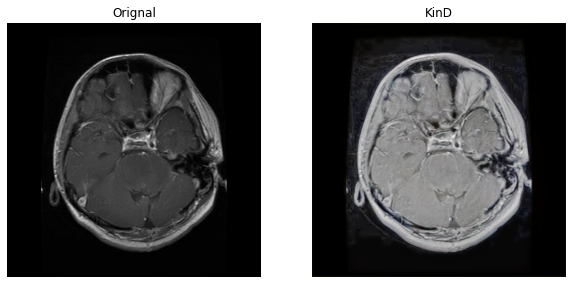

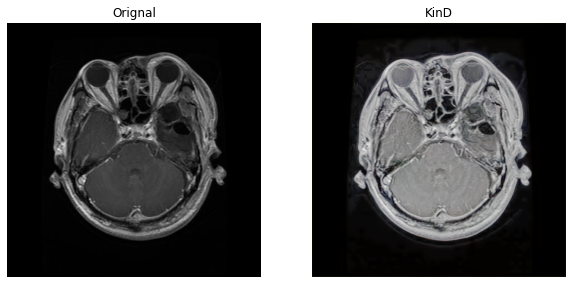

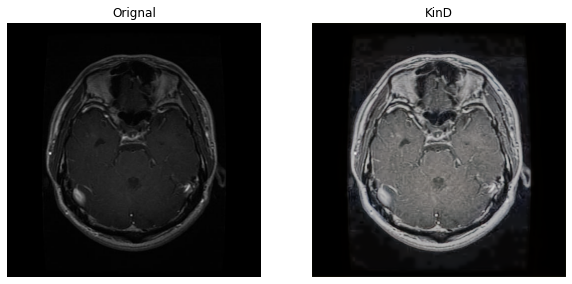

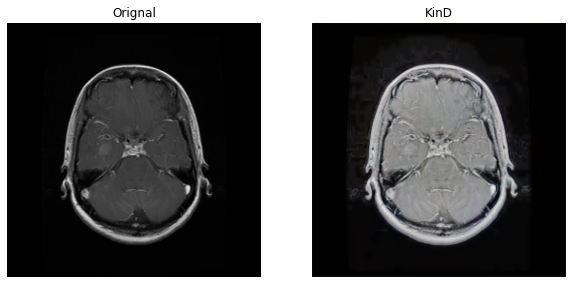

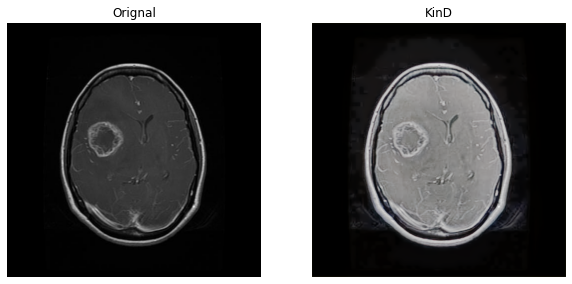

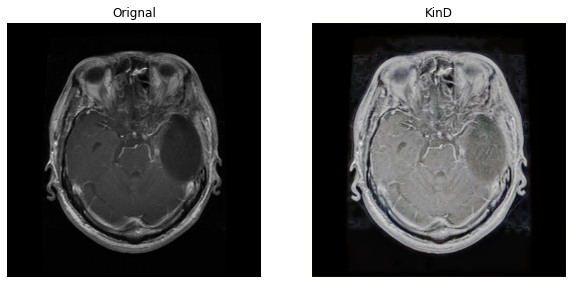

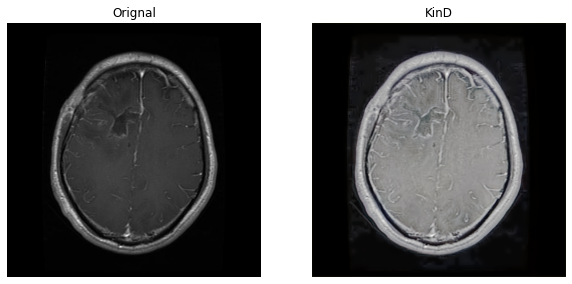

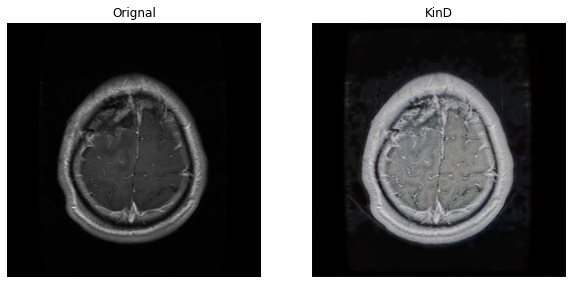

In [8]:
folder1_path = './test/'
folder2_path = './results/test/'

folder1_images = os.listdir(folder1_path)
folder2_images = os.listdir(folder2_path)

num_images = min(len(folder1_images), len(folder2_images))

for i in range(num_images):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Load and display image from folder 1
    image1_path = os.path.join(folder1_path, folder1_images[i])
    image1 = Image.open(image1_path)
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title('Orignal')

    # Load and display image from folder 2
    image2_path = os.path.join(folder2_path, folder2_images[i])
    image2 = Image.open(image2_path)
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title('KinD')

    plt.savefig(os.path.join(folder2_path, 'Combine_picture_[%d].png' % (i)))

    plt.show()